# ***Exploratory Data Analysis: "Twitter Sentiment Analysis - 2012 US Election"***

Acknowledgements: https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model

In [3]:
import pandas as pd
import nltk
import re
from sklearn import *
import time
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from nltk.metrics.distance  import edit_distance
from imblearn.over_sampling import SMOTE
from collections import Counter
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
from palettable.colorbrewer.qualitative import Pastel1_7
import plotly.express as px
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch


import warnings
warnings.filterwarnings("ignore")

In [63]:
def dataClean(tweets_raw):
    cleanTweets = []
    for tweet in tweets_raw:
        tweet = tweet.lower() #convert to lowercase
        tweet = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet) #remove URL
        tweet = re.sub(r'(\s)@\w+', r'', tweet) #remove usernames
        tweet = re.sub(r'@\w+', r'', tweet) #remove usernames
        tweet = re.sub('<[^<]+?>', '', tweet) #remove HTML tags
        # tweet = re.sub(r'[<>!#@$:.,%\?-]+', r'', tweet) #remove punctuation and special characters
        tweet = re.sub('[^A-Za-z0-9 ]+', '', tweet)
        tweet = re.sub(" \d+", " ", tweet) #remove standalone numbers
        lower_case = tweet.lower() #tokenization
        
        words = lower_case.split()
        tweet = ' '.join([w for w in words if not w in nltk.corpus.stopwords.words("english")]) #remove stopwords
        ps = nltk.stem.PorterStemmer()
        stemmedTweet = [ps.stem(word) for word in tweet.split(" ")]
        stemmedTweet = " ".join(stemmedTweet)
        tweet = str(stemmedTweet)
        tweet = tweet.replace("'", "")
        tweet = tweet.replace("\"","")
        cleanTweets.append(tweet)
        
    return cleanTweets

In [147]:
trainingFile = "training-Obama-Romney-tweets.xlsx"
df_obama = pd.read_excel(trainingFile,sheet_name='Obama')
df_romney = pd.read_excel(trainingFile,sheet_name='Romney')

In [148]:
df_obama.drop(df_obama.columns[0], axis=1, inplace = True)
df_obama.drop(df_obama.columns[4:], axis=1, inplace = True)

df_obama.drop([0],inplace=True)
df_obama.rename(columns={df_obama.columns[3]: 'Class'}, inplace = True)

In [149]:
df_romney.drop(df_romney.columns[0], axis=1, inplace = True)
df_romney.drop(df_romney.columns[4:], axis=1, inplace = True)

df_romney.drop([0],inplace=True)
df_romney.rename(columns={df_romney.columns[3]: 'Class'}, inplace = True)

In [150]:
df_obama = df_obama[(df_obama['Class'].isin((1,-1)))]
df_romney = df_romney[(df_romney['Class'].isin((1,-1)))]

In [24]:
obama_tweets_raw = df_obama['Anootated tweet']
obama_class = df_obama['Class']
romney_tweets_raw = df_romney['Anootated tweet']
romney_class = df_romney['Class']

In [25]:
obama_tweets_raw = obama_tweets_raw.tolist()
romney_tweets_raw = romney_tweets_raw.tolist()

In [26]:
obama_class_train = obama_class.tolist()
romney_class_train = romney_class.tolist()

In [27]:
obama_tweets = dataClean(obama_tweets_raw)
romney_tweets = dataClean(romney_tweets_raw)

In [70]:
obama_df = pd.DataFrame(obama_tweets, columns=['Tweet Text'])
obama_df['Class'] = obama_class_train

romney_df = pd.DataFrame(romney_tweets, columns=['Tweet Text'])
romney_df['Class'] = romney_class_train

In [88]:
obama_df['Num_word_text'] = obama_df['Tweet Text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
romney_df['Num_word_text'] = romney_df['Tweet Text'].apply(lambda x:len(str(x).split())) #Number Of words in main text

# ***Exploratory Data Analysis: Obama Tweets***

### Distribution of Class: Obama

[Text(0.5, 1.0, 'Obama Training Data Distribution')]

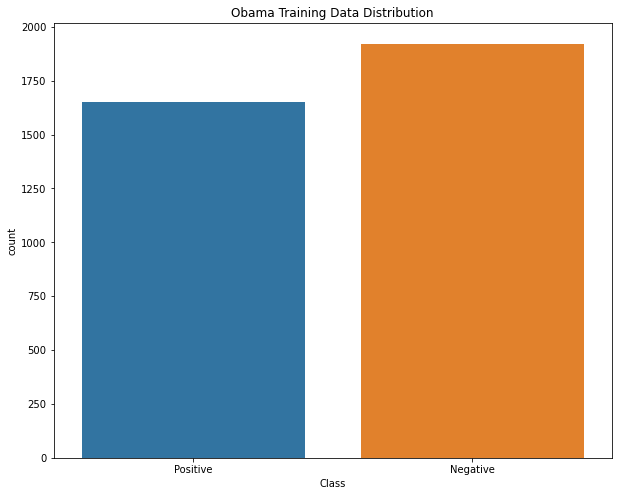

In [154]:
plt.figure(figsize=(10,8))
sns.countplot(x='Class',data=df_obama.replace({-1: 'Negative', 1: 'Positive'})).set(title='Obama Training Data Distribution')

### Kernel Distribution of Number of Words Per Tweet: Obama

Text(0.5, 0, 'Number of Words in Text')

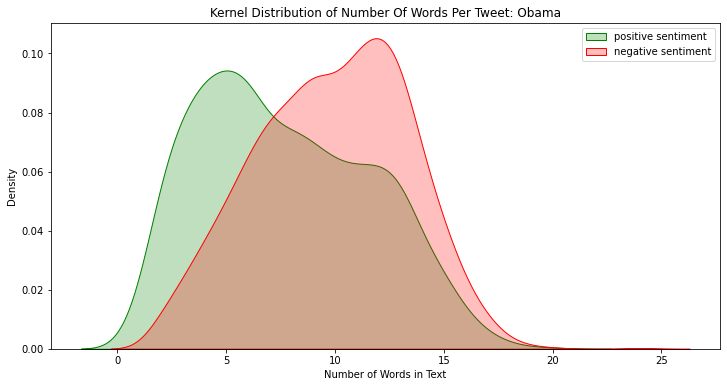

In [131]:
plt.figure(figsize=(12,6))
p1 = sns.kdeplot(obama_df[obama_df['Class']==1]['Num_word_text'], shade=True, color="g")
p1 = sns.kdeplot(obama_df[obama_df['Class']==-1]['Num_word_text'], shade=True, color="r").set_title('Kernel Distribution of Number Of Words Per Tweet: Obama')
plt.legend(labels=['positive sentiment','negative sentiment'])
plt.xlabel('Number of Words in Text')

In [93]:
obama_df['temp_list'] = obama_df['Tweet Text'].apply(lambda x:str(x).split())

In [159]:
Positive_sent_obama = obama_df[obama_df['Class']==1]
Negative_sent_obama = obama_df[obama_df['Class']==-1]

### Most Common Words in Positive Obama Tweets

In [123]:
top_obama = Counter([item for sublist in Positive_sent_obama['temp_list'] for item in sublist])
temp_positive_obama = pd.DataFrame(top_obama.most_common(10))
temp_positive_obama.columns = ['Common_words','count']
print("Most Common words in Positive Obama Tweets are:")
temp_positive_obama.style.background_gradient(cmap='Greens')

Most Common words in Positive Obama Tweets are:


,Common_words,count
0,obama,1693
1,debat,335
2,presid,245
3,vote,231
4,win,153
5,romney,133
6,tonight,115
7,im,88
8,job,80
9,say,73


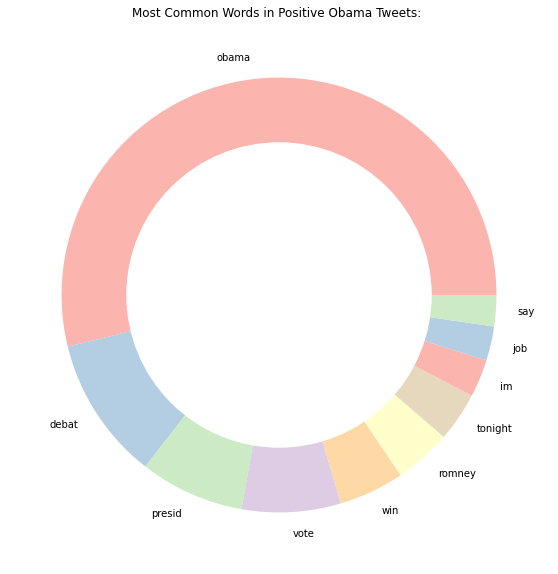

In [134]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(temp_positive_obama['count'], labels=temp_positive_obama.Common_words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Most Common Words in Positive Obama Tweets: ')
plt.show()

### Most Common Words in Negative Obama Tweets

In [124]:
top_obama = Counter([item for sublist in Negative_sent_obama['temp_list'] for item in sublist])
temp_negative_obama = pd.DataFrame(top_obama.most_common(10))
temp_negative_obama.columns = ['Common_words','count']
print("Most Common words in Negative Obama Tweets are:")
temp_negative_obama.style.background_gradient(cmap='Reds')

Most Common words in Negative Obama Tweets are:


,Common_words,count
0,obama,1918
1,debat,210
2,lie,184
3,presid,168
4,vote,140
5,like,127
6,romney,124
7,peopl,114
8,job,101
9,get,98


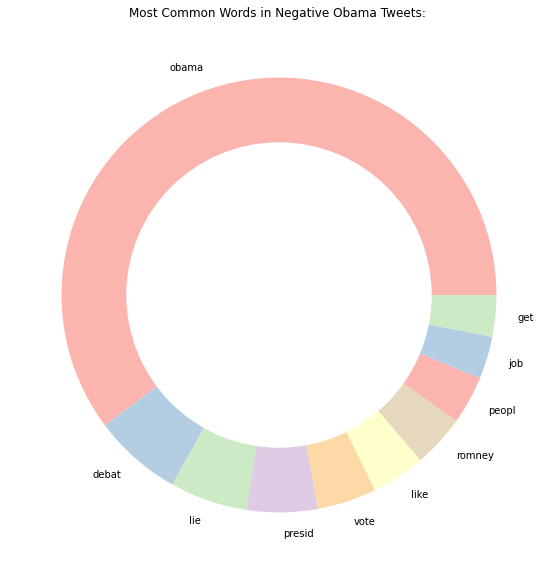

In [135]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(temp_negative_obama['count'], labels=temp_negative_obama.Common_words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Most Common Words in Negative Obama Tweets: ')
plt.show()

In [106]:
raw_text = [word for word_list in obama_df['temp_list'] for word in word_list]

In [112]:
def words_unique(sentiment,numwords,raw_words):
    
    allother = []
    for item in obama_df[obama_df.Class != sentiment]['temp_list']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in obama_df[obama_df.Class == sentiment]['temp_list']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

### Top 10 Unique Words in Positive Obama Tweets

In [125]:
Unique_Positive= words_unique(1, 10, raw_text)
print("Top 10 unique words in Positive Obama Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

Top 10 unique words in Positive Obama Tweets are:


,words,count
0,teamobama,22
1,brought,11
2,uppercut,9
3,prayer,8
4,knock,8
5,cours,7
6,fourmoreyear,6
7,grab,6
8,binder,6
9,narrow,6


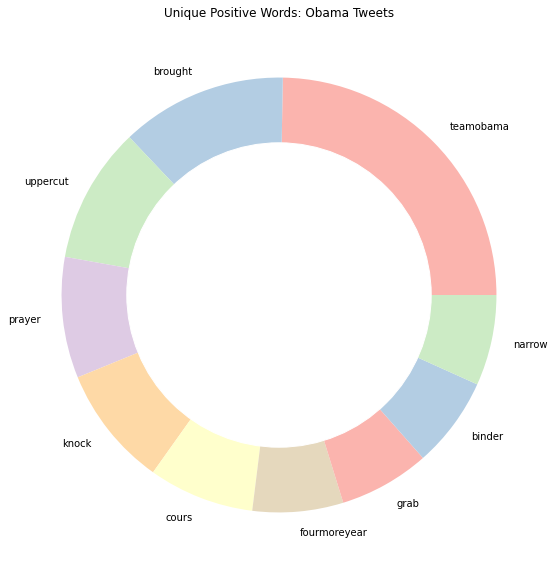

In [137]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Unique Positive Words: Obama Tweets')
plt.show()

### Top 10 Unique Words in Negative Obama Tweets

In [129]:
Unique_Negative= words_unique(-1, 10, raw_text)
print("Top 10 unique words in Negative Obama Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

Top 10 unique words in Negative Obama Tweets are:


,words,count
0,coverup,22
1,weak,19
2,green,18
3,israel,16
4,bankruptci,16
5,bailout,15
6,admin,15
7,a123,14
8,romneyryan2012,14
9,mistak,14


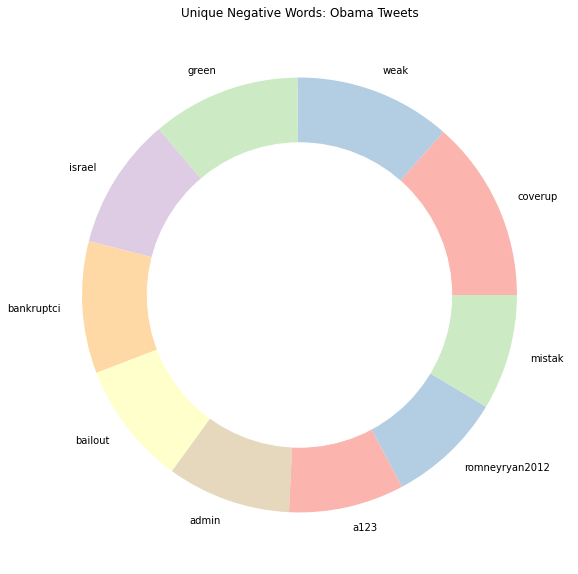

In [139]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Unique Negative Words: Obama Tweets')
plt.show()

# ***Exploratory Data Analysis: Romney Tweets***

### Distribution of Class: Romney

[Text(0.5, 1.0, 'Romney Training Data Distribution')]

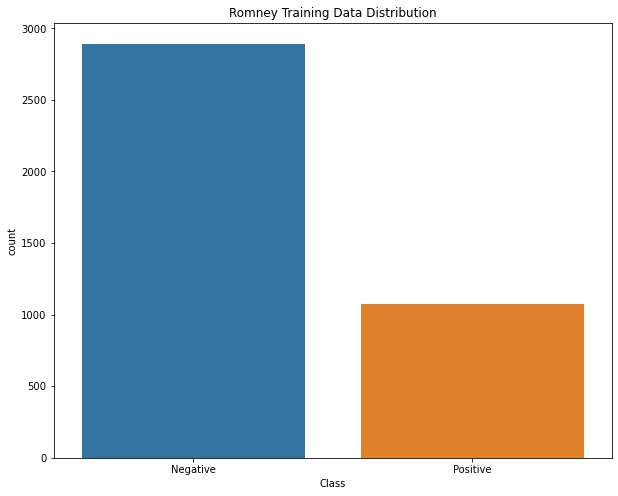

In [156]:
plt.figure(figsize=(10,8))
sns.countplot(x='Class',data=df_romney.replace({-1: 'Negative', 1: 'Positive'})).set(title='Romney Training Data Distribution')

### Kernel Distribution of Number of Words Per Tweet: Romney

Text(0.5, 0, 'Number of Words in Text')

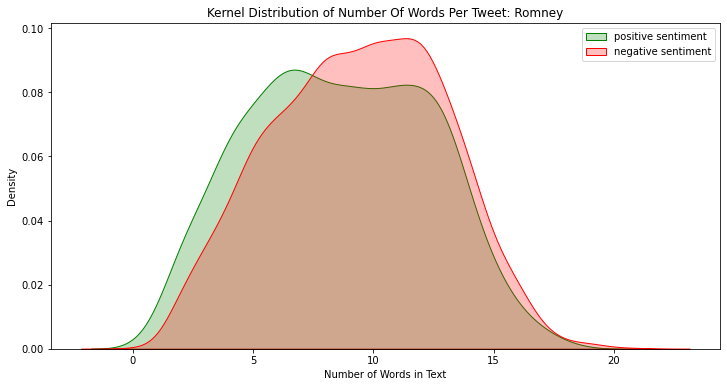

In [157]:
plt.figure(figsize=(12,6))
p1 = sns.kdeplot(romney_df[romney_df['Class']==1]['Num_word_text'], shade=True, color="g")
p1 = sns.kdeplot(romney_df[romney_df['Class']==-1]['Num_word_text'], shade=True, color="r").set_title('Kernel Distribution of Number Of Words Per Tweet: Romney')
plt.legend(labels=['positive sentiment','negative sentiment'])
plt.xlabel('Number of Words in Text')

In [158]:
romney_df['temp_list'] = romney_df['Tweet Text'].apply(lambda x:str(x).split())

In [161]:
Positive_sent_romney = romney_df[romney_df['Class']==1]
Negative_sent_romney = romney_df[romney_df['Class']==-1]

### Most Common Words in Positive Romney Tweets

In [169]:
top_romney = Counter([item for sublist in Positive_sent_romney['temp_list'] for item in sublist])
temp_positive_romney = pd.DataFrame(top_romney.most_common(10))
temp_positive_romney.columns = ['Common_words','count']
print("Most Common words in Positive Romney Tweets are:")
temp_positive_romney.style.background_gradient(cmap='Greens')

Most Common words in Positive Romney Tweets are:


,Common_words,count
0,romney,1018
1,mitt,227
2,vote,144
3,obama,137
4,debat,129
5,win,94
6,poll,79
7,presid,75
8,go,56
9,lead,51


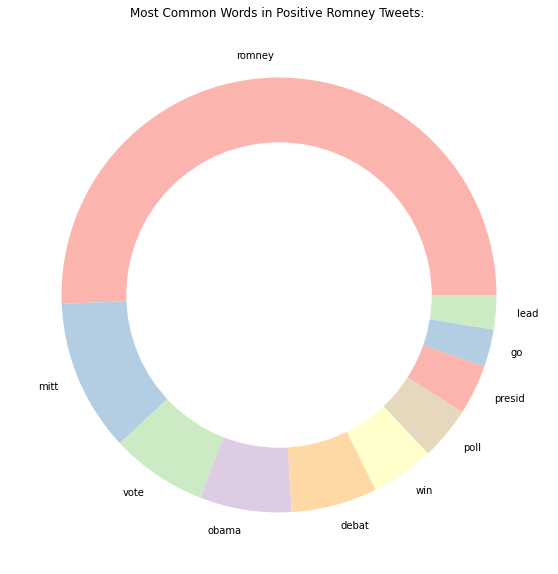

In [167]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(temp_positive_romney['count'], labels=temp_positive_romney.Common_words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Most Common Words in Positive Romney Tweets: ')
plt.show()

### Most Common Words in Negative Romney Tweets

In [168]:
top_romney = Counter([item for sublist in Negative_sent_romney['temp_list'] for item in sublist])
temp_negative_romney = pd.DataFrame(top_romney.most_common(10))
temp_negative_romney.columns = ['Common_words','count']
print("Most Common words in Negative Romney Tweets are:")
temp_negative_romney.style.background_gradient(cmap='Reds')

Most Common words in Negative Romney Tweets are:


,Common_words,count
0,romney,2711
1,mitt,718
2,debat,276
3,plan,252
4,job,250
5,tax,226
6,like,225
7,vote,225
8,obama,205
9,dont,182


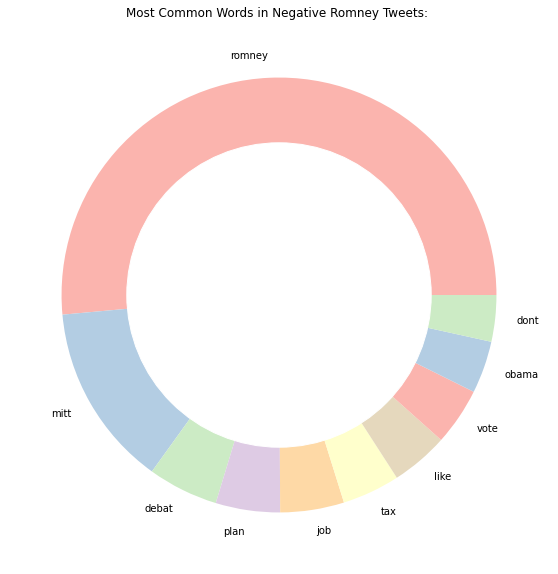

In [170]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(temp_negative_romney['count'], labels=temp_negative_romney.Common_words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Most Common Words in Negative Romney Tweets: ')
plt.show()

In [171]:
raw_text = [word for word_list in romney_df['temp_list'] for word in word_list]

In [172]:
def words_unique(sentiment,numwords,raw_words):
    
    allother = []
    for item in romney_df[romney_df.Class != sentiment]['temp_list']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in romney_df[romney_df.Class == sentiment]['temp_list']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

### Top 10 Unique Words in Positive Romney Tweets

In [173]:
Unique_Positive= words_unique(1, 10, raw_text)
print("Top 10 unique words in Positive Romney Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

Top 10 unique words in Positive Romney Tweets are:


,words,count
0,romney2012,14
1,crowd,9
2,pennsylvania,8
3,pa,8
4,luck,6
5,prayer,6
6,morgan,6
7,past,5
8,lean,5
9,survey,5


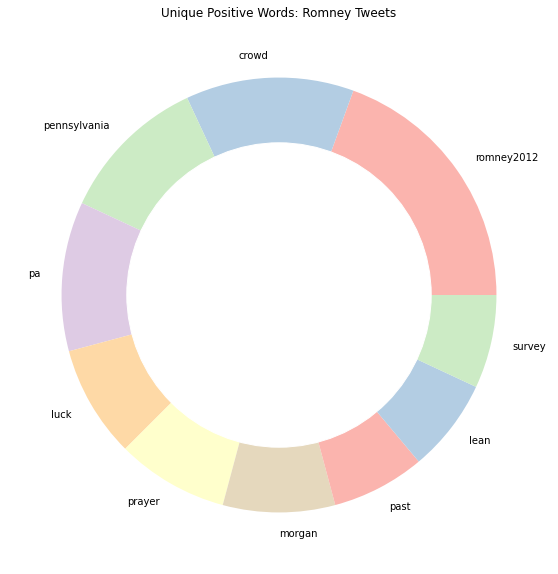

In [174]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Unique Positive Words: Romney Tweets')
plt.show()

### Top 10 Unique Words in Negative Romney Tweets

In [178]:
Unique_Negative= words_unique(-1, 10, raw_text)
print("Top 10 unique words in Negative Romney Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

Top 10 unique words in Negative Romney Tweets are:


,words,count
0,massachusett,24
1,hear,22
2,bindersfullofwomen,22
3,bogu,20
4,entir,20
5,fake,19
6,chines,18
7,disrespect,17
8,profit,16
9,dumb,16


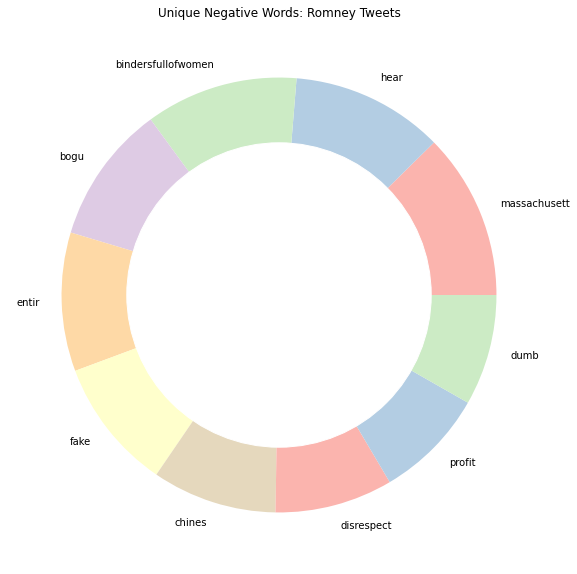

In [177]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Unique Negative Words: Romney Tweets')
plt.show()